In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from astropy import modeling
from astropy.modeling import models, fitting
import math
import itertools
import operator
#from pypulse.dynamicspectrum import DynamicSpectrum
from matplotlib.colors import LogNorm   

In [2]:
#Formatting

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

In [8]:
#GBT A,B,E,F,G
bandwidth = 400 #MHz
centfreq = 800 #MHz
file_duration = 83.33 #ms
#GBT C
#file_duration = 333.33
#GBT D
#file_duration = 166.68

#GMRT A
#file_duration = 163.84 #ms
#
##GMRT B
#bandwidth = 200
#centfreq = 400
#file_duration = 122.88 #ms


### Define Reduced Chi Square

In [9]:
def reduced_chi_square(fit, x, y, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/np.sqrt(np.abs(y))**2))

### Load in Numpy Arrays

In [10]:
#F0 = 12 - 83.33 ms
npyA = np.load('A_117_dm348.8.fits.npy')
npyB = np.load('B_686_dm348.8.fits.npy')
npyB_hires = np.load('GBT_B.dm348.8_16kchan.npy')

#F0 = 3 - 333.33 ms
npyC = np.load('C_1164_dm348.8_lores.npy')

#F0 = 6 - 166.66 ms
npyD = np.load('D_267_dm348.8_lores.npy')

#F0 = 12 - 83.33 ms
npyE = np.load('E_579_dm348.8.fits.npy')
npyE_hires = np.load('GBT_E.dm348.8_16kchan.npy')
npyF = np.load('F_639_dm348.8.fits.npy')
npyG = np.load('G_1549_dm348.8.fits.npy')

#F0 = ambiguous
npyGMRTA = np.load('GMRT_A.dynamicspec_348.8.npy')
npyGMRTB = np.load('GMRT_B.dynamicspec_349.19.npy')

print('A:', npyA.shape)
print('B:', npyB.shape)
print('B_hires: ', npyB_hires.shape)
print('C:', npyC.shape)
print('D:', npyD.shape)
print('E:', npyE.shape)
print('E_hires: ', npyE_hires.shape)
print('F:', npyF.shape)
print('G:', npyG.shape)
print('GMRTA:', npyGMRTA.shape)
print('GMRTB:', npyGMRTB.shape)

A: (7680, 4096)
B: (7680, 4096)
B_hires:  (16000, 1024)
C: (2048, 2048)
D: (1024, 2048)
E: (7680, 4096)
E_hires:  (16000, 1024)
F: (7680, 4096)
G: (7680, 4096)
GMRTA: (2048, 2000)
GMRTB: (2048, 1500)


In [11]:
npy = npyA

### Subband Numpy Array

In [12]:
bw = float(bandwidth) #MHz
cfreq = float(centfreq) #MHz

tres = file_duration / npy.shape[1]
print('Raw Time Resolution (microsec): ', tres*1e3)
nchan = npy.shape[0]
fres = bw / nchan
print('Raw Frequency Resolution (kHz): ', fres*1e3)

#Sub-band data
subfac = 128
sub = np.nanmean(npy.reshape(-1, subfac, npy.shape[1]), axis=1)
subts = sub.sum(0) / np.max(sub.sum(0))
subsp = sub.sum(1) / np.max(sub.sum(1))
subchan = nchan / subfac
subfres = bw / subchan
print('Sub Frequency Resolution (kHz): ', subfres*1e3)

Raw Time Resolution (microsec):  20.34423828125
Raw Frequency Resolution (kHz):  52.083333333333336
Sub Frequency Resolution (kHz):  6666.666666666667


### Smooth in Freq. & Time

In [13]:
#Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
twinlen = sub.shape[1] // 20
if twinlen % 2 == 0:
    twinlen = twinlen + 1
swinlen = sub.shape[0] // 2
if swinlen % 2 == 0:
    swinlen = swinlen + 1
polyo = 6
savts_2d = ss.savgol_filter(sub, twinlen, polyo, axis=1)
savsp_2d = ss.savgol_filter(sub, swinlen, polyo, axis=0)

#print('DYN Time Window Length', twinlen)
#print('DYN Freq Window Length', swinlen)

### Determine & Crop to Pulse Time Width

Red. Chi Square:  0.010351496025844113
Crop Time Bin Right 3324
Crop Time Bin Left 2581
Burst Time Width (ms): 15.113571867325927+/-0.6207992266634987


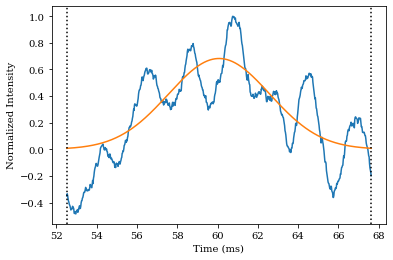

In [17]:
#Calculate initial guess parameters timeseries - normalized by div by max
savts = savts_2d.sum(0) / np.max(savts_2d.sum(0))
maximts = np.max(savts)
stdts = np.std(savts)
meants = np.where(savts == maximts)[0][0]
xts = np.linspace(0, len(savts), len(savts))

#Fit 1D Gaussian to Timeseries
fitterts = modeling.fitting.LevMarLSQFitter()
modelts = modeling.models.Gaussian1D(amplitude=maximts, mean=meants, stddev=stdts)
fitted_modelts = fitterts(modelts, xts, savts)
std_unc = np.sqrt(np.diag(fitterts.fit_info['param_cov']))[2]/fitted_modelts.stddev[0]

#RCS Fit Check
n_free = len(fitted_modelts.parameters)
N = len(xts)
rchisq = reduced_chi_square(fitted_modelts(xts), xts, savts, N, n_free)
print("Red. Chi Square: ", rchisq)

#Crop pulse to 1/2 pulse width on either side
pulsewidth = 3 * fitted_modelts.parameters[2] #3sigma
rcut = int(fitted_modelts.parameters[1] + pulsewidth)
lcut = int(fitted_modelts.parameters[1] - pulsewidth)
if rcut >= len(savts):
    rcut = len(savts)
if lcut <= 0:
    lcut = 0

#Cropped & Subbanded Dynamic Spectrum
sub_c = sub[:, lcut:rcut] 

#DIAGNOISTIC#
#plt.imshow(sub_c, aspect = 'auto')

print('Crop Time Bin Right', rcut)
print('Crop Time Bin Left', lcut)

#Burst Time Width
twidth = 2* (fitted_modelts.stddev * 3) * tres
print('Burst Time Width (ms): ' + str(twidth) + '+/-' + str(twidth*std_unc))

plt.plot(xts[lcut:rcut]*tres, savts[lcut:rcut])
plt.plot(xts[lcut:rcut]*tres, fitted_modelts(xts)[lcut:rcut])
plt.axvline(fitted_modelts.mean*tres + 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.axvline(fitted_modelts.mean*tres - 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Intensity')
plt.show()

### Generate Secondary Spectrum

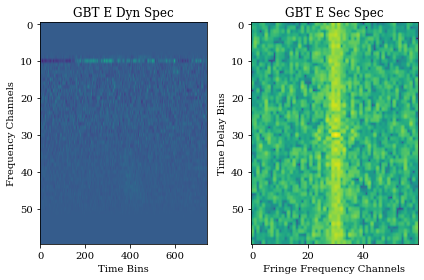

In [16]:
subfactor = 128
sub = np.nanmean(npy.reshape(-1, subfactor, npy.shape[1]), axis=1)
sub_c = sub[:, lcut:rcut]
secspec = np.abs(np.fft.fftshift(np.fft.fft2(sub_c)))**2
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(sub_c[:, :], interpolation = None, aspect = 'auto')
#plt.axvline(fitted_modelts.mean + 3*fitted_modelts.stddev, c = 'w', linestyle = 'dotted')
#plt.axvline(fitted_modelts.mean - 3*fitted_modelts.stddev, c = 'w', linestyle = 'dotted')
plt.title('GBT E Dyn Spec')
plt.xlabel('Time Bins')
plt.ylabel('Frequency Channels')
ax1 = fig.add_subplot(122)
plt.imshow(secspec[secspec.shape[0]//2-30:secspec.shape[0]//2+30, secspec.shape[1]//2-30:secspec.shape[1]//2+30], norm=LogNorm(), aspect = 'auto')
plt.title('GBT E Sec Spec')
plt.xlabel('Fringe Frequency Channels')
plt.ylabel('Time Delay Bins')
plt.tight_layout()
#fig.savefig('GBT_E.secspec.png')
plt.show()

In [507]:
#acf_test = ss.correlate(npy[8000:9100, lcut+20:rcut-20], npy[8000:9100, lcut+20:rcut-20], mode = 'full', method = 'auto')
#x = np.linspace (0, acf_test.shape[0], acf_test.shape[0])
#plt.scatter(x*fres, acf_test.sum(1)/np.max(acf_test.sum(1)))

### Determine Pulse Bandwidth (& Crop if Desired)

In [508]:
subsp_c_nonorm = sub_c.sum(1)
subsp_c = subsp_c_nonorm / np.max(subsp_c_nonorm) #normalize

#print("Sub Dyn Spec Shape: ", sub_c.shape)

savsp_c_nonorm = savsp_2d[:, lcut:rcut].sum(1)
savsp_c = savsp_c_nonorm / np.max(savsp_c_nonorm) #normalize

#Calculate initial guess parameters spectrum - normalized by div by max
maximsp = np.max(savsp_c)
stdsp = np.std(savsp_c)
meansp = np.where(savsp_c == maximsp)[0][0]
xsp = np.linspace(0, len(savsp_c), len(savsp_c))

#Fit 1D Gaussian to Spectrum
fittersp = modeling.fitting.LevMarLSQFitter()
modelsp = modeling.models.Gaussian1D(amplitude=maximsp, mean=meansp, stddev=stdsp)
fitted_modelsp = fittersp(modelsp, xsp, savsp_c)

#Fit Check
n_free = len(fitted_modelsp.parameters)
N = len(xsp)
rchisq = reduced_chi_square(fitted_modelsp(xsp), xsp, savsp_c, N, n_free)
print("Red. Chi Square: ", rchisq)

swidth = 2 * (fitted_modelsp.stddev[0] * 3) * subfres
print('Burst Spectral Width (MHz): ', swidth)
print('Burst Centroid Frequency (MHz): ', fitted_modelsp.mean[0]*subfres + (cfreq - bw/2))

#Crop Frequency (if desired -- not automatic)
dcut = 8000
dbw = round(((dcut / npy.shape[0]) * bw) + (cfreq - bw//2))
ucut = 8800
ubw = round(((ucut / npy.shape[0]) * bw) + (cfreq - bw//2))

bwcut = round(ubw - dbw)
#print('Cropped Bandwidth: ' + str(bwcut) + ' MHz ' + 'between ' + str(ubw) + ' and ' + str(dbw))

cfcut = (((((ucut + dcut)/2) / npy.shape[0]) * bw) + (cfreq - bw//2))
print('Subband Spectral Width: ', (ucut - dcut)*fres)
#print('Cropped Center Frequency (MHz): ', cfcut)
#print(fitted_modelsp.stddev[0])

Red. Chi Square:  4.5358117789284975
Burst Spectral Width (MHz):  222.92593312331306
Burst Centroid Frequency (MHz):  371.0125117410532
Subband Spectral Width:  78.125


### Determine Scattering Timescale

Model: Exponential1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             tau        
    ------------------ ------------------
    0.9343225624497871 -69.09027005108483
Scattering Timescale (ms): 5.659874922584869+/-0.26749680187081853
Red. Chi Square:  5.226617901127341


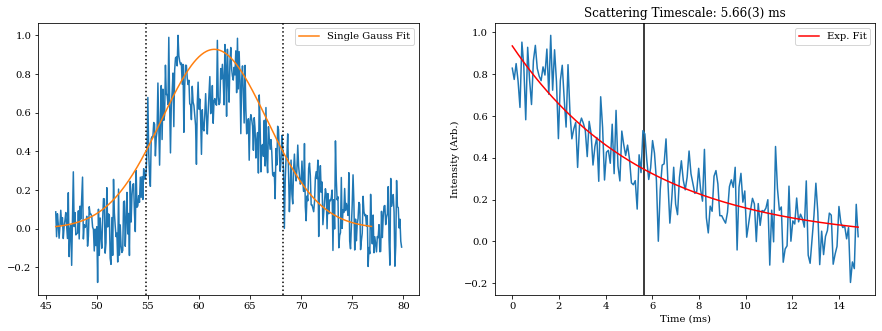

In [509]:
#Isolate Scattering Tail and Calculate Initial Fit Parameters
#For multicomponent bursts (adjust std fraction to improve fit)

exp = subts[int(fitted_modelts.mean[0]+fitted_modelts.stddev[0]/8) : rcut]

#exp = subts[int(fitted_modelts.mean[0]) : rcut+36]

#For coherent bursts

#exp = subts[int(fitted_modelts.mean[0]) : rcut]
xexp = np.linspace(0, len(exp), len(exp))
maxim = np.max(exp)

#Fit to scattering tail
fitterts = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Exponential1D(amplitude=maxim, tau=-53.)
fitted_model = fitterts(model, xexp, exp)
print(fitted_model)
tau_unc = np.sqrt(np.diag(fitterts.fit_info['param_cov']))[1]/fitted_model.tau[0]
halfmax = fitted_model.amplitude[0] / math.e
hm_idx = (np.abs(exp-halfmax)).argmin()
t_idx = np.where(exp == exp[hm_idx])[0][0]
hm = xexp[t_idx]*tres
scat_ts = np.abs(fitted_model.tau[0]*tres)
scat_ts_unc = np.abs(scat_ts*tau_unc)

print('Scattering Timescale (ms): ' + str(scat_ts) + '+/-' + str(scat_ts_unc))

#Fit Check
n_free = len(fitted_model.parameters)
N = len(xexp)
rchisq = reduced_chi_square(fitted_model(xexp), xexp, exp, N, n_free)
print("Red. Chi Square: ", rchisq)

#Plot
fig = plt.figure(figsize = (15,5))
fig.add_subplot(121)
xsubts = np.linspace(0, len(subts), len(subts))[lcut:rcut+36]
plt.plot(xsubts*tres, subts[lcut:rcut+36])
#plt.plot(xts[lcut:rcut+36]*tres, savts[lcut:rcut+36], c = 'k')
plt.axvline(fitted_modelts.mean*tres + 1.3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.axvline(fitted_modelts.mean*tres -1.3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.plot(xts[lcut:rcut]*tres, fitted_modelts(xts)[lcut:rcut], label = 'Single Gauss Fit')
plt.legend()
fig.add_subplot(122)
plt.axvline(x=np.abs(fitted_model.tau[0]*tres), c= 'k')
plt.plot(xexp*tres, exp)
plt.plot(xexp*tres, fitted_model(xexp), c = 'r', label = 'Exp. Fit')#, label = 'tau = ' + str('%s' % float('%.3g' % fitted_model.tau[0])))
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (Arb.)')
plt.title('Scattering Timescale: ' + str('%s' % float('%.3g' % scat_ts)) + \
          '(' + str('%s' % float('%.1g' % scat_ts_unc)).split('.')[1][-1] + ')' + ' ms')
plt.legend()

plt.show()
#fig.savefig('E_scatts.png')
#fig.savefig(str(npy) + '_Scatts.png')

### Fit Timeseries for Multiple Components

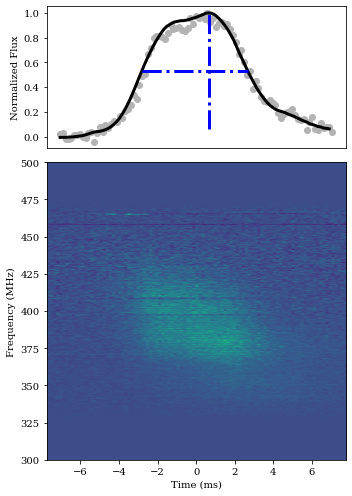

Peaks Locations:  [53]
Peak Locations + lcut:  71 71 18 18 18


In [449]:
#Fit Multiple Gaussian Components to Burst (by eye for now)

x = np.linspace(0, sub.shape[1], sub.shape[1])

xgg = x[lcut:rcut]

x_c = np.linspace(0, len(xgg), len(xgg))

smoothts = savts[lcut:rcut]
datagg = sub.sum(0)[lcut:rcut] / np.max(sub.sum(0)[lcut:rcut])

#Peaks
gausspks = ss.find_peaks(smoothts)[0]

#Peak Widths
gausspkwd = ss.peak_widths(smoothts, gausspks)
threepkwdidx = np.sort(gausspkwd[0])[-3:]

#Peak Prominences
gausspkprm = ss.peak_prominences(smoothts, gausspks)
threepkprmidx = np.sort(gausspkprm[0])[-3:]

#gausspklocsidx = [np.where(gausspkwd[0] == i)[0][0] for i in threepkwdidx]
gausspklocsidx = [np.where(gausspkprm[0] == i)[0][0] for i in threepkprmidx]

fig = plt.figure(figsize = (5, 7))

grid = fig.add_gridspec(9, 1)

ax1 = fig.add_subplot(grid[0:3, 0])

plt.scatter(x_c, datagg, c = '0.7', zorder = 1)
plt.plot(smoothts, c = 'k', zorder = 2, linewidth = 3)
contour_heights = smoothts[gausspks] - gausspkprm[0]
plt.vlines(x=gausspks, ymin=contour_heights, ymax=smoothts[gausspks], color = 'b', zorder = 3, linestyle = 'dashdot', linewidth = 3)
plt.hlines(*gausspkwd[1:], color='b', zorder = 4, linestyle = 'dashdot', linewidth = 3)
#plt.title('Main Peaks (In Prep. for Subburst Fitting)')
plt.ylabel('Normalized Flux')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax3 = fig.add_subplot(grid[-6:, 0])

twidth = sub_c.shape[1] * tres

plt.imshow(sub_c, extent = [-twidth/2, twidth/2, 300, 500], interpolation = None, aspect = 'auto')
#plt.imshow(npy_sub, interpolation = None, aspect = 'auto')
#plt.ylim(nymin//subfactor, nymax//subfactor)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.tight_layout()

plt.show()
fig.savefig('AAS_GMRT_A.png')

#Gaussian Maximum Locations
gausspklocs = gausspks[gausspklocsidx]

print('Peaks Locations: ', gausspklocs)

a0 = lcut
a1 = lcut
a2 = lcut
a3 = lcut
a4 = lcut

try:
    a0 = lcut + gausspklocs[0]
    a1 = lcut + gausspklocs[1]
    a2 = lcut + gausspklocs[2]
    a3 = lcut + gausspklocs[3]
    a4 = lcut + gausspklocs[4]
except IndexError:
    try:
        a0 = lcut + gausspklocs[0]
        a1 = lcut + gausspklocs[1]
        a2 = lcut + gausspklocs[2]
        a3 = lcut + gausspklocs[3]
    except IndexError:
        try:
            a0 = lcut + gausspklocs[0]
            a1 = lcut + gausspklocs[1]
            a2 = lcut + gausspklocs[2]
        except IndexError:
            try:
                a0 = lcut + gausspklocs[0]
                a1 = lcut + gausspklocs[1]
            except IndexError:
                a1 = lcut + gausspklocs[0]

print('Peak Locations + lcut: ', a0, a1, a2, a3, a4)

Iteration limit reached    (Exit mode 9)
            Current function value: 0.275630863111573
            Iterations: 100
            Function evaluations: 1621
            Gradient evaluations: 100
Iteration limit reached
Red. Chi Square:  -0.4467680346066876


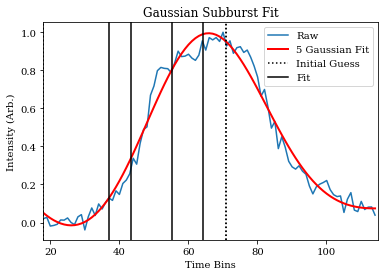

In [450]:
gg_init = models.Gaussian1D(1., a0, 60.) + models.Gaussian1D(1., a2, 60.) + models.Gaussian1D(1., a2, 60.)\
    + models.Gaussian1D(1., a3, 60.) + models.Gaussian1D(1., a4, 60.)
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, xgg, datagg)
print(fitter.fit_info['message'])

#Fit Check
n_free = len(gg_fit.parameters)
N = len(xgg)
rchisq = reduced_chi_square(gg_fit(xgg), xgg, datagg, N, n_free)
print("Red. Chi Square: ", rchisq)


fig = plt.figure()
#plt.plot(                xgg*tres, datagg)
plt.plot(                xgg, datagg , label = 'Raw')
plt.plot(                xgg, gg_fit(xgg), lw=2, c='r', label = '5 Gaussian Fit')
plt.axvline(a0, c = 'k', linestyle = 'dotted', label = 'Initial Guess')
plt.axvline(a1, c = 'k', linestyle = 'dotted')
plt.axvline(a2, c = 'k', linestyle = 'dotted')
plt.axvline(a3, c = 'k', linestyle = 'dotted')
plt.axvline(a4, c = 'k', linestyle = 'dotted')
plt.axvline(gg_fit.mean_0[0], c = 'k', label = 'Fit')
plt.axvline(gg_fit.mean_1[0], c = 'k')
plt.axvline(gg_fit.mean_2[0], c = 'k')
plt.axvline(gg_fit.mean_3[0], c = 'k')
plt.axvline(gg_fit.mean_4[0], c = 'k')
plt.xlabel('Time Bins')
plt.ylabel('Intensity (Arb.)')
plt.title('Gaussian Subburst Fit')
plt.xlim(lcut, rcut)
plt.legend()
plt.show()
#fig.savefig(str(npy) + '_sbfit.png')
fig.savefig('GMRTA_sbfit.png')

### Generate Timeseries Histogram

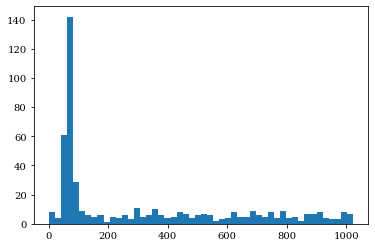

In [451]:
#Get Localization Histogram

secs = sub.shape[np.int(0)]

# Make dictionary of 1D timeseries' or spectra depending on axis
# 1 key per sample.
tsdict = {}

# Find maximum values for each array in the dictionary.
maxvals = []

# Find the array element location of these maximum values.
yvals = []

# Make a linspace to plot the yvals against.
xtent = sub.shape[np.int(0)]
xvals = np.linspace(0, np.int(xtent), num=np.int(xtent))
slices = np.split(sub, secs, axis=np.int(0))

for i in range(secs):
    tsdict[i] = np.ravel(slices[i])
    maxvals.append(np.max(tsdict[i]))
    y = list(np.where(tsdict[i] == tsdict[i].max()))

    # Replace RFI/already ommitted channels that, as expected,
    # contain multiple maximum vals with 0
    for n, i in enumerate(y):
        if len(i) > 1:
            y[n] = 0
    yvals.append(np.int(y[0]))
    
arr = np.asarray((np.linspace(0, len(yvals), len(yvals)), yvals))
plt.hist(arr[1], 50)
plt.show()

### Determine Labels and Label Locations for Plotting

Subband Spectral Width: 


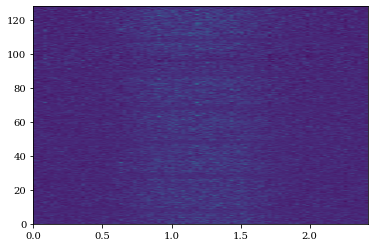

In [452]:
#Frequency
flabel_noend = np.arange(cfreq - bw/2, cfreq+ bw/2, step=round(bw/(2*bw/100)))
flabels = np.flip(np.append(flabel_noend, [cfreq + bw/2]))
#flabels = np.flip(flabel_noend)
flabellocs = np.arange(0, sub_c.shape[0], step=sub_c.shape[0]/round((2*bw/100)))
#print('FLabel locs: ', flabellocs)
#print('Flables: ', flabels)

#Time
tbin = sub_c.shape[1]
#print('Tbins: ', tbin)
tlabellocs = np.arange(0, tbin, step=round(tbin/round(tres*tbin)))
tlabels_noend = np.arange(0, tbin*tres, step=round(tbin*tres/round(tres*tbin)))
tlabels = tlabels_noend#np.append(tlabels_noend, [round(tbin*tres)])
#print('TLabel locs: ', tlabellocs)
#print('Tlables: ', tlabels)

npys_c = npy[dcut:ucut, lcut:rcut]
flabel_noend_c = np.arange(dbw, ubw, step=bwcut/8)
flabels_c_noround = np.flip(np.append(flabel_noend_c, [cfcut + bwcut/2]))
flabels_c = [float('%s' % float('%.5g' % i)) for i in flabels_c_noround]
flabellocs_c = np.arange(0, npys_c.shape[0], step=npys_c.shape[0]/(len(flabels_c)-1))

plt.imshow(npys_c, extent = [0, npys_c.shape[1]*fres, 0, npys_c.shape[0]*tres], aspect = 'auto')
print('Subband Spectral Width: ', )
#print('Zoom FLabel locs: ', flabellocs_c)
#print('Zoom Flables: ', flabels_c)

##Zoom Time
#tbin = sub_c.shape[1]
#tlabellocs = np.arange(0, sub_c.shape[1], step=round(sub_c.shape[1]/8))
#tlabels_noend = np.arange(0, sub_c.shape[1]*tres, step=round(sub_c.shape[1]*tres/8))
#tlabels = np.append(tlabels_noend, [round(sub_c.shape[1]*tres)])
#print('TLabel locs: ', tlabellocs)
#print('Tlables: ', tlabels)

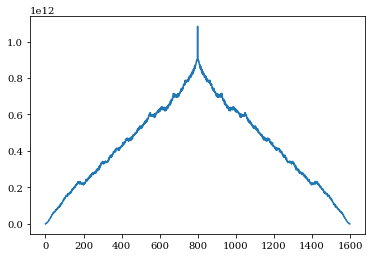

In [453]:
#plt.plot(npys_c.sum(1))
acf_test = ss.correlate(npys_c, npys_c)
plt.plot(acf_test.sum(1)[:])
plt.show()

In [454]:
npy_zerosub = npy - np.mean(npy[dcut:ucut, 0:lcut]) #subtract zero-mean
acovf2d = ss.correlate(npy_zerosub[dcut:ucut, lcut:rcut], npy_zerosub[dcut:ucut,lcut:rcut])
acf2d = acovf2d[:, :] / acovf2d[acovf2d.shape[0]//2,acovf2d.shape[1]//2]
acfts = ((acf2d.sum(0) / math.e) / np.max(acf2d.sum(0) / math.e)) #div by e
acfsp = acf2d.sum(1) / np.max(acf2d.sum(1))
#print('TS Length: ', len(acfts))
#print('SP Length: ', len(acfsp))

Scintillation Timescale: 4.24 ms


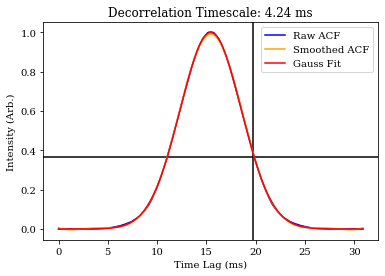

In [455]:
#Lower central peak
for n, i in enumerate(acfts):
    if i == 1.0:
        acfts[n] = np.sort(acfts)[-2]

acfts = acfts / np.max(acfts)
        
#print("2nd Max: ", np.sort(acfts)[-2])
#print(len(acfts)//2+1)
sav_acfts = ss.savgol_filter(acfts, len(acfts)//2+1, 6)
x_acfts = np.linspace(0, len(sav_acfts), len(sav_acfts))
x_acfts_tlag = x_acfts * tres
#print('XTS Length: ', len(x_acfts))

maxim_acfts = np.max(sav_acfts)
std_acfts = np.std(sav_acfts)
mean_acfts = np.where(sav_acfts == maxim_acfts)[0][0]

peaks_acfts = ss.find_peaks(sav_acfts)[0]
peak_1_acfts = peaks_acfts[len(peaks_acfts)//2]
pkwidths_ts = ss.peak_widths(sav_acfts, [peak_1_acfts])[0][0]

#print('Max: ', maxim_acfts)
#print('Std: ', std_acfts)
#print('Mean: ', mean_acfts)

#Fit 1D Gaussian to Timeseries
fitter_acfts = modeling.fitting.LevMarLSQFitter()
#modelts = modeling.functional_models.Exponential1D(amplitude=maximts, tau=-1.)
#modelts = modeling.models.Lorentz1D(amplitude=maximts, x_0=meants, fwhm=pkwidths)
model_acfts = modeling.models.Gaussian1D(amplitude=maxim_acfts, mean=mean_acfts, stddev=1.)
fitted_model_acfts = fitter_acfts(model_acfts, x_acfts, acfts)
fit_acfts = fitted_model_acfts(x_acfts)
#print(fitted_model_acfts)

#Fit Check
n_free = len(fitted_model_acfts.parameters)
N = len(x_acfts)
rchisq = reduced_chi_square(fitted_model_acfts(x_acfts), x_acfts, acfts, N, n_free)
#print("Red. Chi Square: ", rchisq)

pks_acfts = ss.find_peaks(fit_acfts)[0]
pp_acfts = ss.peak_prominences(fit_acfts, pks_acfts)[0]
fwhm_acfts = ss.peak_widths(fit_acfts, pks_acfts)[0]
st = ((fwhm_acfts) * tres) / 2
#st = fitted_modelts.fwhm[0]*tres / 2
#print('Peak: ', pks_acfts)
#print('Pprom: ', pp_acfts)
#print('FWHM: ', fwhm_acfts)
#print('Scintillation Timescale (ms): ', st)

emax = fitted_model_acfts.amplitude[0] / math.e
#print('Emax: ', emax)
em_idx = (np.abs(acfts-emax)).argmin()
#print('EM_idx: ', em_idx)
et_idx = np.where(acfts == acfts[em_idx])[0][0]
#print('ET_idx: ', et_idx)
#em = acfts[et_idx]*tres
print('Scintillation Timescale: ' + str(np.abs((len(acfts)/2*tres) - et_idx*tres)) + ' ms')

fig = plt.figure()
plt.axhline(emax, c = 'k')
plt.axvline(et_idx*tres, c = 'k')
plt.plot(x_acfts_tlag, acfts, c = 'blue', label = 'Raw ACF')
plt.plot(x_acfts_tlag, sav_acfts, c = 'orange', label = 'Smoothed ACF')
plt.plot(x_acfts_tlag, fitted_model_acfts(x_acfts), c = 'r', label = 'Gauss Fit')
plt.xlabel("Time Lag (ms)")
plt.ylabel('Intensity (Arb.)')
plt.title('Decorrelation Timescale: ' + str('%s' % float('%.3g' % ((np.abs((len(acfts)/2*tres) - et_idx*tres))))) + ' ms')
plt.legend()
plt.show()
#fig.savefig(str(npy) + '_decorts.png')
fig.savefig('G_decorts.png')

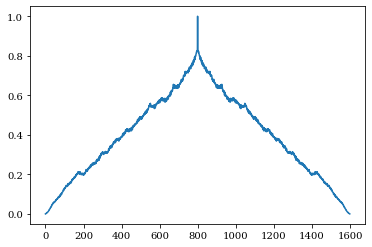

In [456]:
plt.plot(acfsp)

Red. Chi Square:  0.0007284785911537117
Scintillation Bandwidth: 1.225 MHz


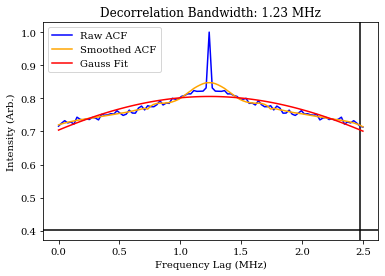

In [435]:
#for n, i in enumerate(acfsp):
#    if i == np.max(acfsp):
#        acfsp[n] = np.sort(acfsp)[-10]
        
acfsp = acfsp[:] / np.max(acfsp[:])

#print("2nd Max: ", np.sort(acfsp)[-2])
#print(int(ucut-dcut)//20+1)
sav_acfsp = ss.savgol_filter(acfsp, int(ucut-dcut)//20+1, 6)
#sav_acfsp = ss.savgol_filter(acfsp, int(ucut-dcut)//2+1, 6)
x_acfsp = np.linspace(0, len(sav_acfsp), len(sav_acfsp))
x_acfsp_flag = x_acfsp * fres

maxim_acfsp = np.max(sav_acfsp)
std_acfsp = np.std(sav_acfsp)
mean_acfsp = np.where(sav_acfsp == maxim_acfsp)[0][0]

peaks_acfsp = ss.find_peaks(sav_acfsp)[0]
peak_1_acfsp = peaks_acfsp[len(peaks_acfsp)//2]
pkwidths_acfsp = ss.peak_widths(sav_acfsp, [peak_1_acfsp])[0][0]

#print('Max: ', maxim_acfsp)
#print('Std: ', std_acfsp)
#print('Mean: ', mean_acfsp)

#Fit 1D Gaussian to Timeseries
fitter_acfsp = modeling.fitting.LevMarLSQFitter()
#model_acfsp = modeling.models.Lorentz1D(amplitude=maxim_acfsp, x_0=mean_acfsp, fwhm=pkwidths_acfsp)
model_acfsp = modeling.models.Gaussian1D(amplitude=1., mean=mean_acfsp, stddev=1.)
fitted_model_acfsp = fitter_acfsp(model_acfsp, x_acfsp, acfsp)
fit_acfsp = fitted_model_acfsp(x_acfsp)

#Fit Check
n_free = len(fitted_model_acfsp.parameters)
N = len(x_acfsp)
rchisq = reduced_chi_square(fitted_model_acfsp(x_acfsp), x_acfsp, acfsp, N, n_free)
print("Red. Chi Square: ", rchisq)

fwmax = fitted_model_acfsp.amplitude[0] / 2
#print('Emax: ', emax)
fwm_idx = (np.abs(acfsp-fwmax)).argmin()
#print('EM_idx: ', em_idx)
fwt_idx = np.where(acfsp == acfsp[fwm_idx])[0][0]
#print('FWT_idx: ', fwt_idx)
print('Scintillation Bandwidth: ' + str(np.abs(len(acfsp)//2*fres - fwt_idx*fres)) + ' MHz')
#print('Scintillation Bandwidth: ' + str(np.abs(bwcut - fwt_idx*fres)) + ' MHz' )

#print(fitted_model_acfsp)
#pks_acfsp = ss.find_peaks(fit_acfsp)[0]
#print('Peaks ACF: ', pks_acfsp)
#pp_acfsp = ss.peak_prominences(fit_acfsp, pks_acfsp)
#print('Peak Prominences ACF: ', pp_acfsp)
#fwhm_acfsp = ss.peak_widths(fit_acfsp, pks_acfsp)[0][0]
#print('FWHM_acfsp: ', fwhm_acfsp)
#sb = ((fwhm_acfsp) * fres) / 2
#print('Scintillation Bandwidth (MHz): ', sb)

fig = plt.figure()
plt.axhline(fwmax, c = 'k')
plt.axvline(fwt_idx*fres, c = 'k')
plt.plot(x_acfsp_flag, acfsp, c = 'blue', label = 'Raw ACF')
plt.plot(x_acfsp_flag, sav_acfsp, c = 'orange', label = 'Smoothed ACF')
plt.plot(x_acfsp_flag, fit_acfsp, c = 'r', label = 'Gauss Fit')
plt.xlabel("Frequency Lag (MHz)")
plt.ylabel("Intensity (Arb.)")
plt.title('Decorrelation Bandwidth: ' + str('%s' % float('%.3g' % (np.abs(len(acfsp)//2*fres - fwt_idx*fres)))) + ' MHz')
plt.legend()
plt.show()
#fig.savefig(str(npy) + '_decorbw.png')
fig.savefig('G_decorbw.png')

(500, 89)
XTS:  1024
Lcut, Rcut:  721 810


ValueError: x and y must have same first dimension, but have shapes (500,) and (125,)

<Figure size 1440x1440 with 0 Axes>

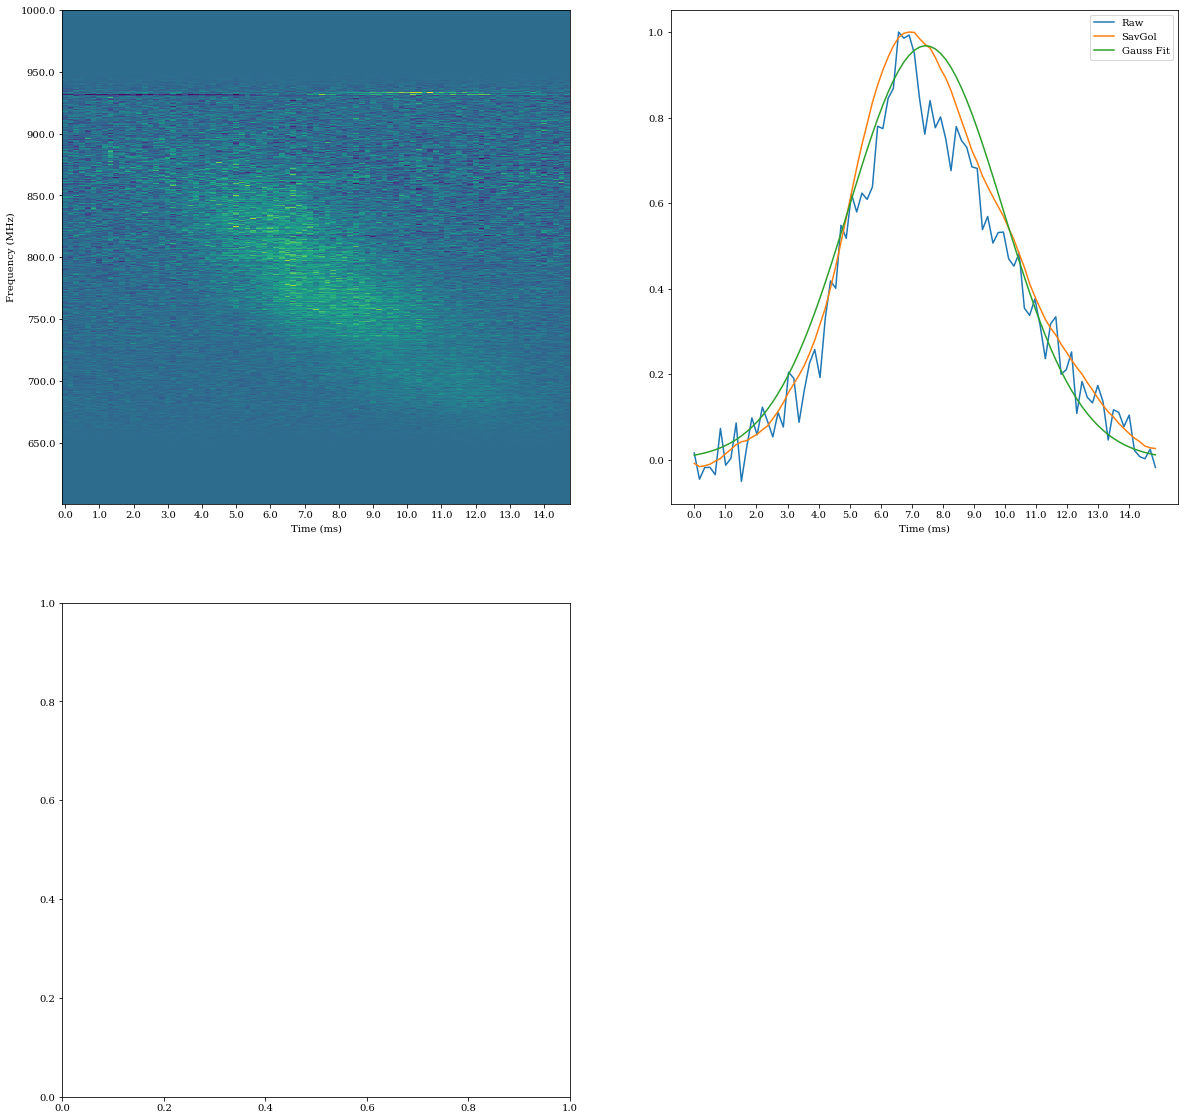

In [410]:
fig = plt.figure(figsize = (20, 20))

print(sub_c.shape)

fig = plt.figure(figsize = (20, 20))

ax = fig.add_subplot(221)
plt.imshow(sub_c, interpolation = 'None', aspect = 'auto')
plt.xticks(tlabellocs, tlabels)
plt.yticks(flabellocs, flabels)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')

print('XTS: ', len(xts))
print('Lcut, Rcut: ', lcut, rcut)

xts_c = xts[lcut:rcut]
x_c = np.linspace(0, len(xts_c), len(xts_c))
subts_c = subts[lcut:rcut]
savts_c = savts[lcut:rcut]
fit_c = fitted_modelts(xts)[lcut:rcut]

ax1 = fig.add_subplot(222)
plt.plot(x_c, subts_c, label = 'Raw')
plt.plot(x_c, savts_c, label = 'SavGol')
plt.plot(x_c, fit_c, label = 'Gauss Fit')
plt.xticks(tlabellocs, tlabels)
plt.xlabel('Time (ms)')
plt.legend()

ax2 = fig.add_subplot(223)
plt.plot(np.flip(subsp_c), xsp, label = 'Raw')
#print('Subsp: ', len(subsp_c))
plt.plot(np.flip(savsp_c), xsp, label = 'SavGol')
plt.plot(np.flip(fitted_modelsp(xsp)), xsp, label = 'Gauss Fit')
#print('XSP: ', len(xsp))
#plt.yticks(flabellocs_c, np.flip(flabels_c))
plt.ylabel('Frequency (MHz)')
plt.legend()

ax3 = fig.add_subplot(224)
plt.imshow(npys_c, interpolation = 'None', aspect = 'auto')
plt.xticks(tlabellocs, tlabels)
plt.yticks(flabellocs_c, flabels_c)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')

#ax4 = fig.add_subplot(325)
#plt.plot(acfts)
#tlabels_acf = np.append(-1*np.flip(tlabels[1:]), tlabels)
#tlabellocs_acf = np.arange(0, len(acfts), step=round(len(acfts)/(2*round(tres*tbin))))
#plt.xticks(tlabellocs_acf, tlabels_acf)
#plt.xlabel('Time (ms)')
#
#ax5 = fig.add_subplot(326)
##plt.plot(acfsp)
#flabels_c_acf = np.flip(np.append(flabels_c, -1*np.flip(flabels_c[:-1])))
#print(flabels_c_acf)
#flabellocs_c_acf = np.arange(0, len(acfsp), step=round(len(acfsp)/(2*round((2*bw/100)))))
#plt.plot(x_acfsp, acfsp, c = 'blue', label = 'Raw ACF')
#plt.plot(x_acfsp, sav_acfsp, c = 'orange', label = 'Smoothed ACF')
#plt.plot(x_acfsp, fit_acfsp, c = 'r', label = 'Gauss Fit')
#plt.xticks(flabellocs_c_acf, flabels_c_acf)
#plt.xlabel("Frequency Lag (MHz)")
#plt.ylabel("Amplitude")
#plt.legend()

plt.tight_layout()
plt.show()

#fig.savefig(str(npy) + '_fourplot.png')

#fig.savefig(str(burst_npy) + '_dyn_ts.png')
fig.savefig('G_fourplot.png')